# 1.Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import shap
import warnings
import math

from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

warnings.filterwarnings("ignore")

In [ ]:
path="/GAHE-ML/"
graphic_path=path+"/plot_revision2/"

# 2.Load The Dataset

In [4]:
dataset = pd.read_csv(f"{path}data_sicaklik3.csv", header=0, sep=";")

# 3.Separating independent(X) and dependent(y) variables

In [ ]:
X = dataset.iloc[:, 0:6]
y = dataset.iloc[:, 6]

# 4.Data Distribution Graphic

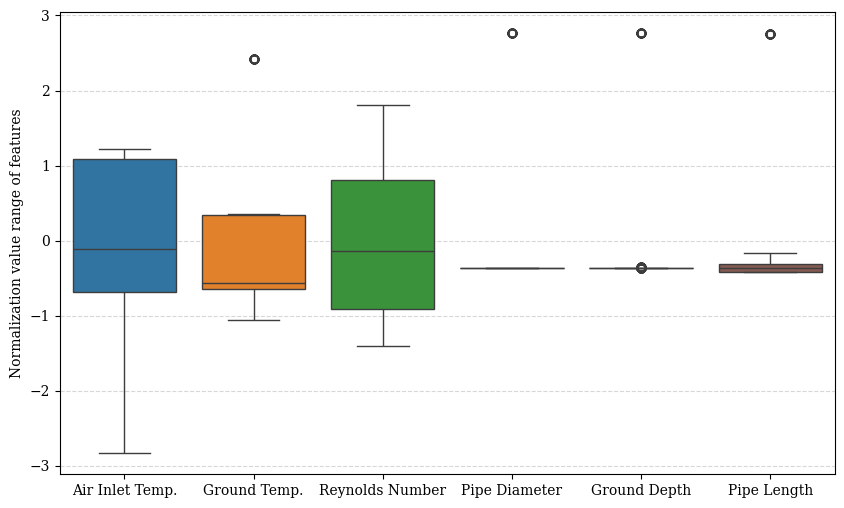

In [ ]:
# Eğitim verisini normalize edip boxplot çiziyoruz
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_normalized)
plt.xticks(ticks=range(6), labels=["Air Inlet Temp.", "Ground Temp.", "Reynolds Number", "Pipe Diameter", "Ground Depth", "Pipe Length"])
# plt.title('Feature Distribution of Dataset')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.ylabel("Normalization value range of features")
plt.savefig(f"{graphic_path}dataset_distribution.png", dpi=600)
plt.show()

# 5.Models and hyperparameter grids to be used

In [ ]:
# Kullanılacak modeller ve hiperparametreler
tuned_models = {
    'KNN': (KNeighborsRegressor(), {'model__n_neighbors': [3, 5, 7]}),
    'SVR': (SVR(), {'model__C': [0.1, 1, 10], 'model__epsilon': [0.01, 0.1, 0.2], 'model__kernel': ['linear', 'rbf']}),
    'DT': (DecisionTreeRegressor(), {'model__max_depth': [5, 10, 15, 20, 25, None]}),
    'RF': (RandomForestRegressor(), {'model__n_estimators': [100, 150, 200], 'model__max_depth': [5, 10, 15, 20, 25, None]}),
    'XGB': (XGBRegressor(objective='reg:squarederror'), {'model__n_estimators': [100, 150, 200], 'model__max_depth': [10, 20, 30], 'model__learning_rate': [0.05, 0.1]})
}

# 6.SHAP Analysis Function

In [ ]:
def shap_analysis(best_model, X_train_fold, X_val_fold, feature_names, isDownload=False):
    figsize=(10, 6)
    # Verileri ölçekle
    X_train_scaled = best_model.named_steps["scaler"].transform(X_train_fold)
    X_val_scaled = best_model.named_steps["scaler"].transform(X_val_fold)

    model = best_model.named_steps["model"]

    # SHAP açıklayıcı nesnesi
    explainer = shap.KernelExplainer(model.predict, X_train_scaled)
    shap_values = explainer.shap_values(X_val_scaled)

    # === SHAP Summary Plot ===
    plt.figure(figsize=figsize)
    shap.summary_plot(shap_values, X_val_scaled, feature_names=feature_names, show=False)
    # colorbar objesini al
    cbar = plt.gcf().axes[-1]  # en sağdaki colorbar objesi

    # colorbar'ın genişliğini ayarla (örneğin %2'den %4'e çıkar)
    box = cbar.get_position()
    cbar.set_position([box.x0 + 0.05, box.y0, 0.05, box.height])  # [x, y, genişlik, yükseklik]
    plt.tight_layout()
    if isDownload:
      plt.savefig(f"{graphic_path}shap_summary.png", dpi=600)
    plt.show()

    # === Barplot ===
    shap_abs_values = np.abs(shap_values)
    shap_importance = np.sum(shap_abs_values, axis=0)
    sorted_indices = np.argsort(shap_importance)[::-1]
    sorted_features = np.array(feature_names)[sorted_indices]
    sorted_shap_importance = shap_importance[sorted_indices]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=sorted_shap_importance, y=sorted_features, palette="coolwarm")
    plt.xlabel("SHAP Values")
    plt.tight_layout()
    if isDownload:
      plt.savefig(f"{graphic_path}shap_feature_importance.png", dpi=600)
    plt.show()

    # === Heatmap ===
    plt.figure(figsize=figsize)
    sns.heatmap(shap_values[:, sorted_indices].T, cmap="coolwarm", xticklabels=5, yticklabels=sorted_features)
    plt.xlabel("Samples")
    if isDownload:
      plt.savefig(f"{graphic_path}shap_heatmap.png", dpi=600)
    plt.tight_layout()
    plt.show()

    # === Decision Plot (İlk 50 Örnek) ===
    plt.figure(figsize=figsize)
    shap.decision_plot(
        explainer.expected_value,
        shap_values,
        feature_names=feature_names,
        show=False
    )
    if isDownload:
      plt.savefig(f"{graphic_path}shap_decision.png", dpi=600, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

# 7.Model training and parameter optimization with cross-validation

KNN için GridSearchCV başlatılıyor...
SVR için GridSearchCV başlatılıyor...
DT için GridSearchCV başlatılıyor...
RF için GridSearchCV başlatılıyor...
XGB için GridSearchCV başlatılıyor...


  0%|          | 0/70 [00:00<?, ?it/s]

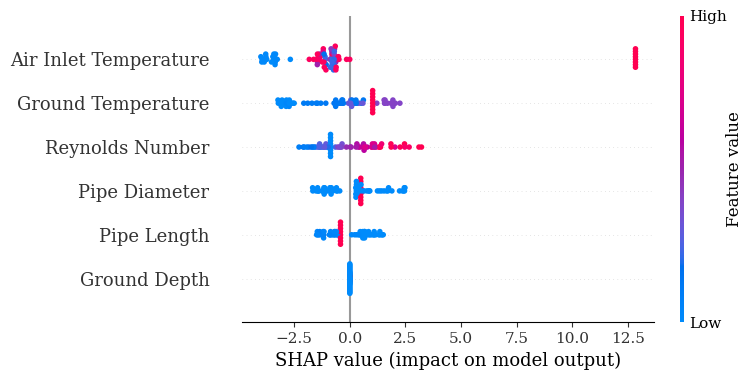

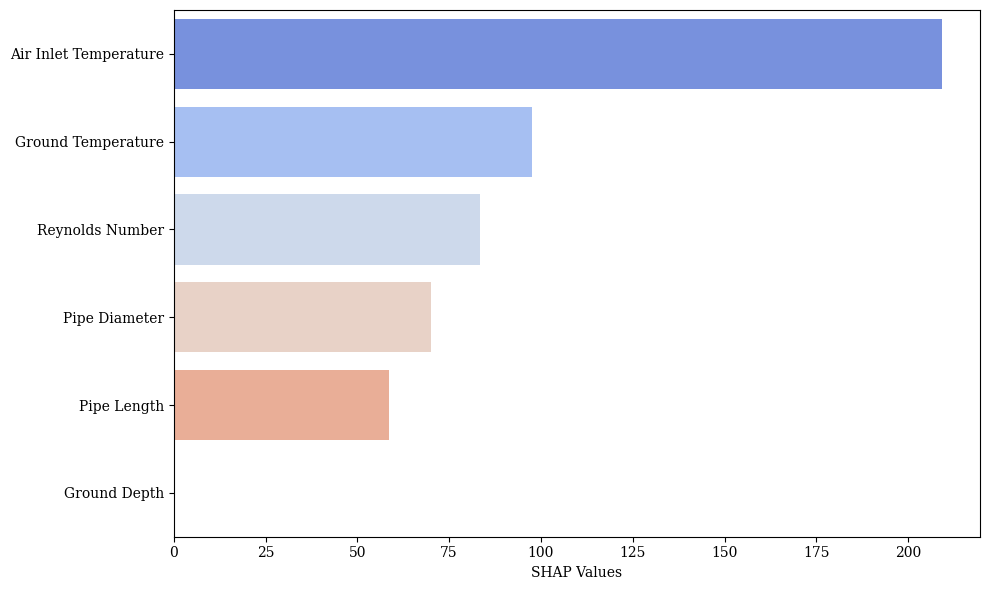

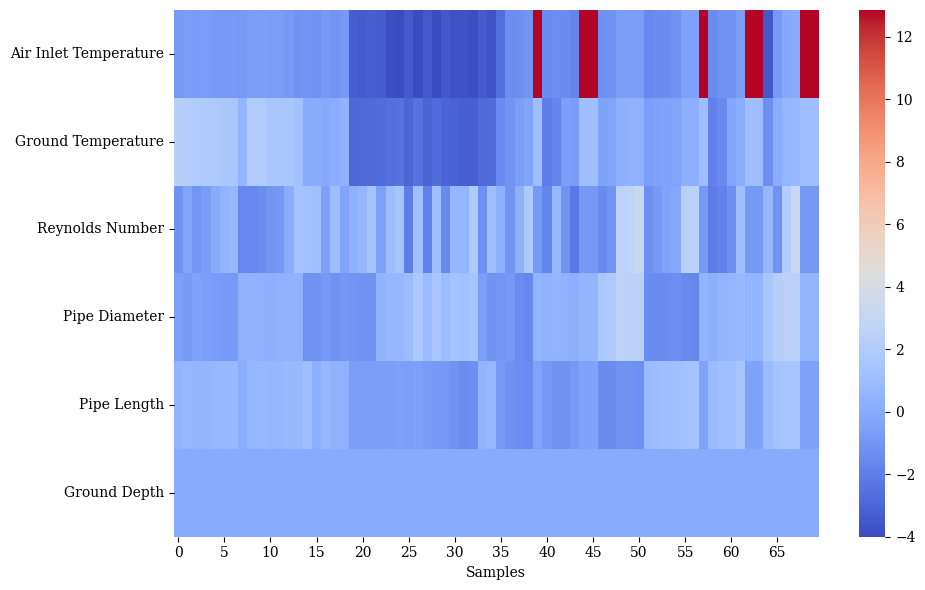

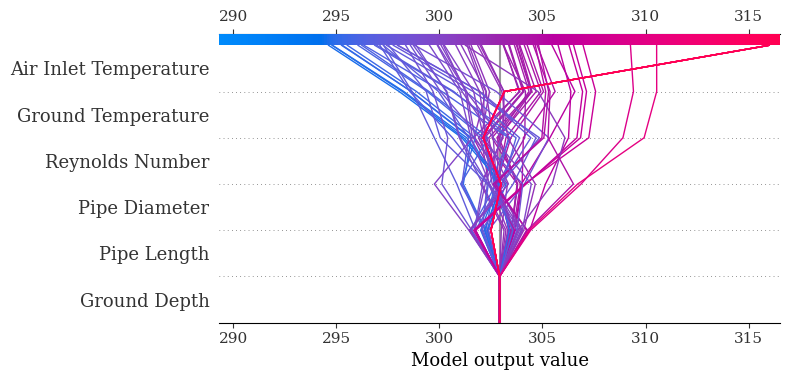

In [ ]:
SEED = 13
cv_results = []
model_best_params = []
merged_df = pd.DataFrame()
merged_df["ActualValues"] = y
k_folds = 5
# 5 katlı çapraz doğrulama nesnesi
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=SEED)
feature_names = ["Air Inlet Temperature", "Ground Temperature", "Reynolds Number", "Pipe Diameter", "Ground Depth", "Pipe Length"]

for name, (model, params) in tuned_models.items():
    print(f"{name} için GridSearchCV başlatılıyor...")
    pipeline = Pipeline([('scaler', StandardScaler()), ('model', model)])
    grid = GridSearchCV(pipeline, param_grid=params, cv=kfold, scoring='neg_mean_squared_error')
    grid.fit(X, y)
    best_model = grid.best_estimator_
    fold_scores = []
    fold_preds = []
    model_best_params.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'best_model': best_model,
        'model_type': type(best_model.named_steps['model']).__name__
    })
    # 5-Fold çapraz doğrulama
    for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(X), 1):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        best_model.fit(X_train, y_train)

        # Doğrulama seti tahmini
        y_val_pred = best_model.predict(X_val)
        # Eğitim seti tahmini
        y_train_pred = best_model.predict(X_train)

        cv_results.append({
        'Model': name,
        'Fold': fold_idx,

        # Doğrulama (Validation) seti metrikleri
        'Val RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred)),
        'Val MAE': mean_absolute_error(y_val, y_val_pred),
        'Val MSE': mean_squared_error(y_val, y_val_pred),
        'Val R2': r2_score(y_val, y_val_pred),

        # Eğitim (Train) seti metrikleri
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Train MSE': mean_squared_error(y_train, y_train_pred),
        'Train R2': r2_score(y_train, y_train_pred)
        })

        fold_scores.append((fold_idx, cv_results[-1]['Val RMSE']))
        fold_preds.append((fold_idx, y_val_pred, y_val.index))  # Tahminleri ve index'leri tut

    # En iyi fold belirlenir
    best_fold_index = min(fold_scores, key=lambda x: x[1])[0]

    # En iyi fold'a ait eğitim ve test bölgesi alınır
    for fold_id, preds, indices in fold_preds:
        if fold_id == best_fold_index:
            # İlgili fold'un index'leri
            train_indices = [i for i in range(len(X)) if i not in indices]
            X_fold_train, y_fold_train = X.iloc[train_indices], y.iloc[train_indices]

            # En iyi fold eğitimi
            best_model.fit(X_fold_train, y_fold_train)

            # Tüm veriye (veya X_test'e) tahmin yapılır
            full_preds = best_model.predict(X)

            # Tahminler her satır için yazılır
            merged_df[f"predicted_{name}"] = full_preds
            if name=='XGB':
              shap_analysis(best_model, X_fold_train, X_val, feature_names, True)

            break

# 8.Fold Result

In [ ]:
# Fold sonuçlarını DataFrame'e çevir
fold_results_df = pd.DataFrame(cv_results)
fold_results_df.to_csv(f"{path}fold_results.csv", index=False)

# 9.Optimum hyper-parameters

In [ ]:
optimum_parameters=pd.DataFrame(model_best_params)
optimum_parameters.to_csv(f"{path}optimum_parameters.csv", index=False)

# 10.Calculate mean and standard deviation

In [ ]:
# Ortalama ve standart sapmayı hesapla
agg_df = fold_results_df.groupby("Model").agg({
    "Train MSE": ['mean', 'std'],
    "Train MAE": ['mean', 'std'],
    "Train RMSE": ['mean', 'std'],
    "Train R2": ['mean', 'std'],
    "Val MSE": ['mean', 'std'],
    "Val MAE": ['mean', 'std'],
    "Val RMSE": ['mean', 'std'],
    "Val R2": ['mean', 'std']
})

# Kolonları düzleştir
agg_df.columns = ['_'.join(col).strip() for col in agg_df.columns.values]
agg_df.reset_index(inplace=True)
best_model_name = agg_df.sort_values("Val RMSE_mean").iloc[0]["Model"]
print(f"Best Model Name: {best_model_name}")
# mean ± std formatı
summary_df = pd.DataFrame()
summary_df['Model'] = agg_df['Model']

metrics = ['MSE', 'MAE', 'RMSE', 'R2']
sets = ['Train', 'Val']

for s in sets:
    for m in metrics:
        mean_col = f"{s} {m}_mean"
        std_col = f"{s} {m}_std"
        summary_df[f"{s} {m}"] = agg_df.apply(lambda row: f"{row[mean_col]:.4f} ± {row[std_col]:.4f}", axis=1)
summary_df
summary_df.to_csv(f"{path}summary_df.csv", index=False)

Best Model Name: XGB


# 11.Random selection of 50 samples for graphs

In [ ]:
merged_df1 = merged_df.sample(n=50, random_state=SEED)
merged_df1 = merged_df1.reset_index(drop=True)

# 12.Comparison of predictive outcomes of ML models

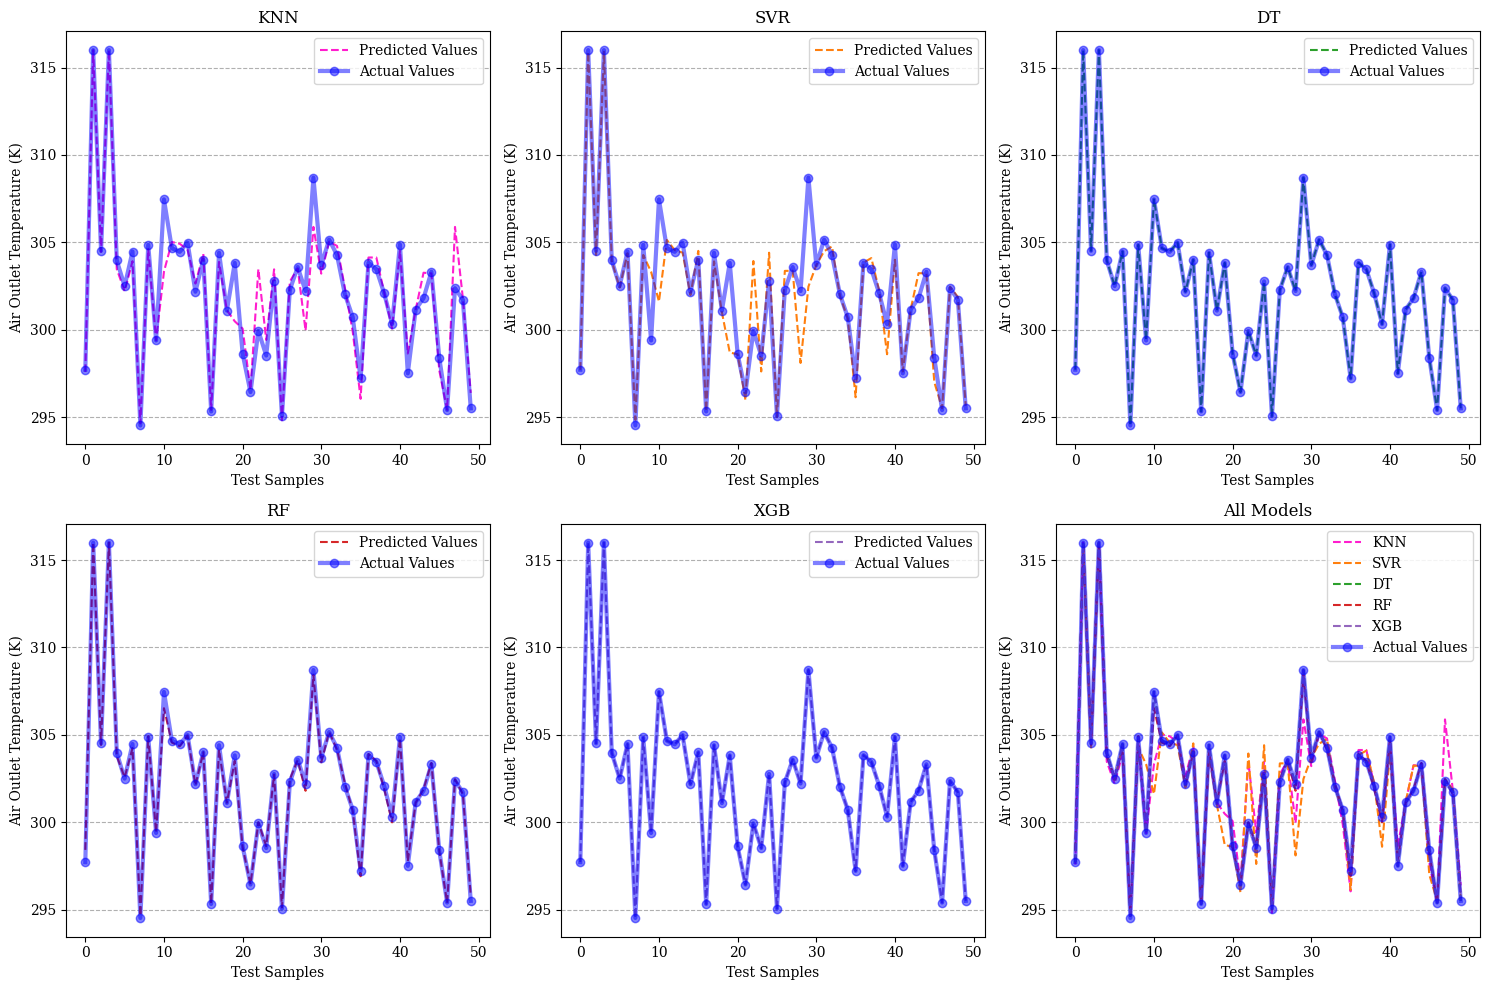

In [ ]:
# Grafik çizimi

colors = [
    '#FF1DCE',  # Koyu Mavi (KNN)
    '#ff7f0e',  # Turuncu (SVR)
    '#2ca02c',  # Yeşil (DT)
    '#d62728',  # Kırmızı (RF)
    '#9467bd'   # Mor (XGB)
]

# Grafik düzeni
num_cols = 3
num_rows = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
axes = axes.flatten()

for i, (model_name, color) in enumerate(zip(tuned_models.keys(), colors)):
    ax = axes[i]

    ax.plot(merged_df1[f"predicted_{model_name}"], label=f"Predicted Values", linestyle='--', color=color)
    ax.plot(merged_df1["ActualValues"], label="Actual Values", color='blue', linestyle='-', linewidth=3, marker='o', alpha=0.5)

    ax.set_xlabel('Test Samples')
    ax.set_ylabel('Air Outlet Temperature (K)')
    ax.set_title(f'{model_name}')
    ax.legend()
    ax.grid(axis='y', linestyle='--')

# Tüm modellerin birlikte çizildiği grafik
ax_all = axes[-1]
for model_name, color in zip(tuned_models.keys(), colors):
    ax_all.plot(merged_df1[f"predicted_{model_name}"], label=f"{model_name}", linestyle='--', color=color)
ax_all.plot(merged_df1["ActualValues"], label="Actual Values", color='blue', linestyle='-', linewidth=3, marker='o', alpha=0.5)
ax_all.set_xlabel('Test Samples')
ax_all.set_ylabel('Air Outlet Temperature (K)')
ax_all.set_title('All Models')
ax_all.legend()
ax_all.grid(axis='y', linestyle='--', alpha=0.7)

# Boş kalan aksları gizle
for j in range(len(tuned_models), len(axes) - 1):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig(f"{graphic_path}tahmingrafigi.png", dpi=600)
plt.show()

# 13.Data distribution between actual and predicted values; the 45° line shows optimal prediction.

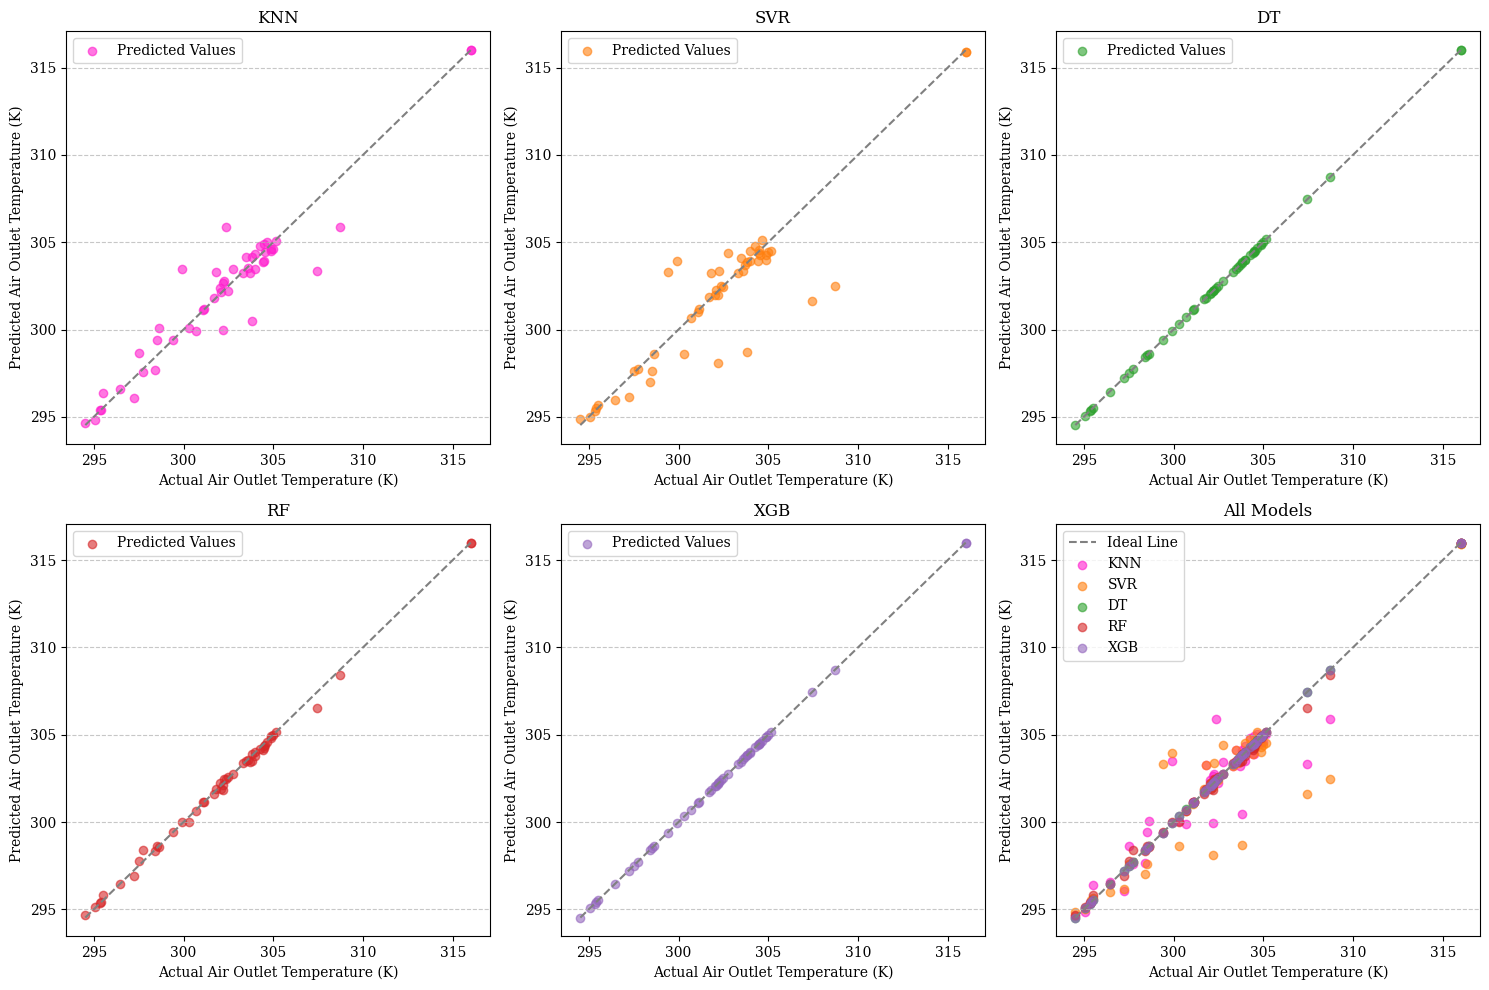

In [ ]:
# Model sayısını alın
total_models = len(tuned_models.keys())

# Dinamik satır ve sütun sayısı
n_cols = 3
n_rows = math.ceil((total_models + 1) / n_cols)
y_test=merged_df1["ActualValues"]
# Grafik figürü ve eksenlerini oluştur
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.ravel()


# Her model için ayrı grafik çiz
for i, (model_name, color) in enumerate(zip(tuned_models.keys(), colors)):
    ax = axes[i]
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color="gray")
    ax.scatter(y_test, merged_df1[f"predicted_{model_name}"], label=f"Predicted Values", color=color, alpha=0.6)

    ax.set_xlabel("Actual Air Outlet Temperature (K)")
    ax.set_ylabel("Predicted Air Outlet Temperature (K)")
    ax.set_title(f"{model_name}")
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Tüm modellerin birlikte olduğu grafik
ax = axes[total_models]
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color="gray", label="Ideal Line")
for model_name, color in zip(tuned_models.keys(), colors):
    ax.scatter(y_test, merged_df1[f"predicted_{model_name}"], label=f"{model_name}", color=color, alpha=0.6)

ax.set_xlabel("Actual Air Outlet Temperature (K)")
ax.set_ylabel("Predicted Air Outlet Temperature (K)")
ax.set_title("All Models")
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Boş hücreleri kaldır
if total_models + 1 < len(axes):
    for j in range(total_models + 1, len(axes)):
        fig.delaxes(axes[j])

# Son işlemler
plt.tight_layout()
plt.savefig(f"{graphic_path}tahmingrafigi_scatter.png", dpi=600)
plt.show()

# 14.CFD Validation Graph

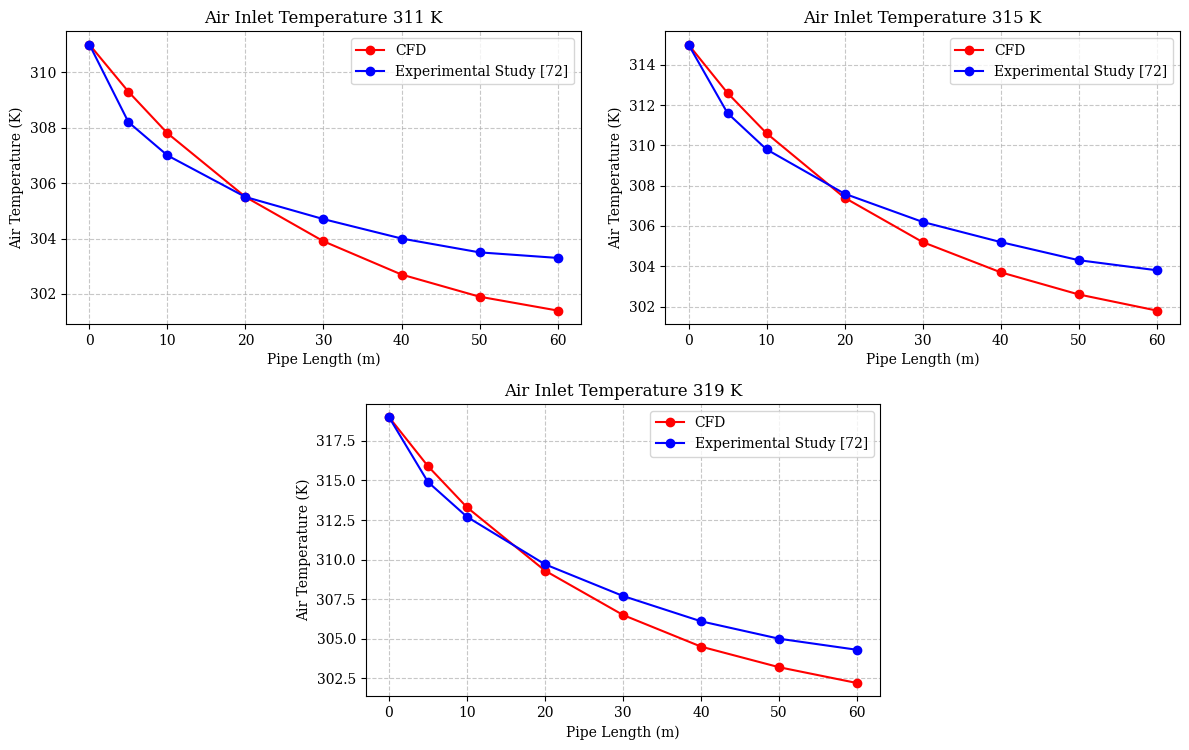

In [ ]:
cfd_validation = pd.read_csv(f"{path}validation_new.csv")
cfd_validation.index=cfd_validation["PL"]
cfd_validation.drop(columns=["PL"], inplace=True)
# Data
pipe_lengths = [0, 5, 10, 20, 30, 40, 50, 60]

# Figure oluştur
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 4)

# Etiket isimleri
y1_label = "CFD"
y2_label = "Experimental Study [72]"

# --- Plot 1 ---
ax1 = plt.subplot(gs[0, 0:2])
ax1.set_title("Air Inlet Temperature 311 K")
line1 = ax1.plot(pipe_lengths, cfd_validation["CFD"][0:8], color='red', linestyle='-', marker='o', label=y1_label)
line2 = ax1.plot(pipe_lengths, cfd_validation["Experimental study"][0:8], color='blue', linestyle='-', marker='o', label=y2_label)
ax1.set_xlabel('Pipe Length (m)')
ax1.set_ylabel('Air Temperature (K)')
ax1.grid(axis='both', linestyle='--', alpha=0.7)
ax1.legend(loc='upper right')

# --- Plot 2 ---
ax2 = plt.subplot(gs[0, 2:4])
ax2.set_title("Air Inlet Temperature 315 K")
ax2.plot(pipe_lengths, cfd_validation["CFD"][8:16], color='red', linestyle='-', marker='o', label=y1_label)
ax2.plot(pipe_lengths, cfd_validation["Experimental study"][8:16], color='blue', linestyle='-', marker='o', label=y2_label)
ax2.set_xlabel('Pipe Length (m)')
ax2.set_ylabel('Air Temperature (K)')
ax2.grid(axis='both', linestyle='--', alpha=0.7)
ax2.legend(loc='upper right')

# --- Plot 3 ---
ax3 = plt.subplot(gs[1, 1:3])
ax3.set_title("Air Inlet Temperature 319 K")
ax3.plot(pipe_lengths, cfd_validation["CFD"][16:24], color='red', linestyle='-', marker='o', label=y1_label)
ax3.plot(pipe_lengths, cfd_validation["Experimental study"][16:24], color='blue', linestyle='-', marker='o', label=y2_label)
ax3.set_xlabel('Pipe Length (m)')
ax3.set_ylabel('Air Temperature (K)')
ax3.grid(axis='both', linestyle='--', alpha=0.7)
ax3.legend(loc='upper right')

# Ortak alanlara göre düzenleme
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Üst boşluk için yer ayır

# Kaydet
plt.savefig(f"{graphic_path}validation.png", bbox_inches='tight', dpi=600)

# Göster
plt.show()

# 15.CFD & De Pape & Ex. Study Comparison

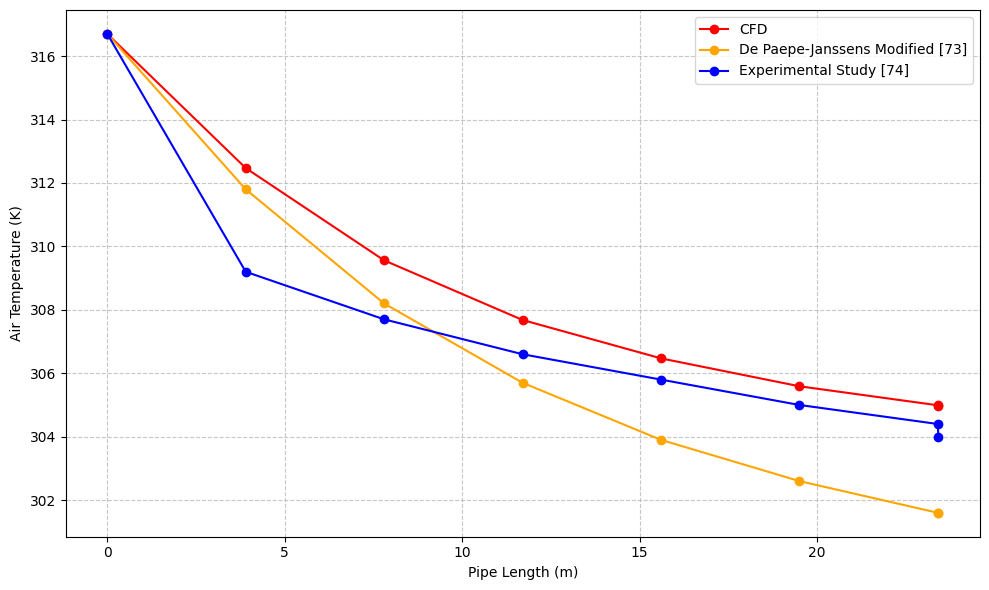

In [31]:
cfd_comparison = pd.read_csv(f"{path}comparison.csv", sep=";")
cfd_comparison.index=cfd_comparison["PL"]
cfd_comparison.drop(columns=["PL"], inplace=True)
plt.figure(figsize=(10, 6))
plt.plot(cfd_comparison.index, cfd_comparison["CFD"], color='red', linestyle='-', marker='o', label="CFD")
plt.plot(cfd_comparison.index, cfd_comparison["PJ"], color='orange', linestyle='-', marker='o', label="De Paepe-Janssens Modified [73]")
plt.plot(cfd_comparison.index, cfd_comparison["ES"], color='blue', linestyle='-', marker='o', label="Experimental Study [74]")


plt.xlabel('Pipe Length (m)')
plt.ylabel('Air Temperature (K)')
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(f"{graphic_path}comparison.png", bbox_inches='tight', dpi=600)
plt.show()

# Read CSV

In [4]:
optimum_parameters = pd.read_csv(f"{path}result_csv/optimum_parameters.csv")

In [12]:
optimum_parameters["Best Params"][0]

"{'model__n_neighbors': 3}"

In [26]:
performance_evaluation_result = pd.read_csv(f"{path}result_csv/summary_df.csv")

In [27]:
performance_evaluation_result

,Model,Train MSE,Train MAE,Train RMSE,Train R2,Val MSE,Val MAE,Val RMSE,Val R2
0,DT,0.0000 ± 0.0000,0.0000 ± 0.0000,0.0000 ± 0.0000,1.0000 ± 0.0000,0.8775 ± 0.4235,0.5417 ± 0.1267,0.9112 ± 0.2430,0.9688 ± 0.0182
1,KNN,1.2971 ± 0.0941,0.6828 ± 0.0243,1.1383 ± 0.0405,0.9601 ± 0.0032,2.9751 ± 0.3434,1.0998 ± 0.1054,1.7224 ± 0.1034,0.8984 ± 0.0373
2,RF,0.0448 ± 0.0030,0.1284 ± 0.0044,0.2115 ± 0.0070,0.9986 ± 0.0002,0.4231 ± 0.1665,0.3857 ± 0.0420,0.6406 ± 0.1264,0.9850 ± 0.0089
3,SVR,2.6104 ± 0.1166,0.8854 ± 0.0220,1.6154 ± 0.0358,0.9198 ± 0.0054,2.7417 ± 0.3923,0.9355 ± 0.0874,1.6522 ± 0.1216,0.9086 ± 0.0301
4,XGB,0.0000 ± 0.0000,0.0011 ± 0.0001,0.0016 ± 0.0002,1.0000 ± 0.0000,0.3794 ± 0.1283,0.3438 ± 0.0581,0.6075 ± 0.1136,0.9870 ± 0.0057


In [24]:
columns_to_convert = [
    "Train MSE", "Train MAE", "Train RMSE", "Train R2",
    "Val MSE", "Val MAE", "Val RMSE", "Val R2"
]
def round_pm(value):
    try:
        mean, std = value.split('±')
        mean = round(float(mean.strip()), 2)
        std = round(float(std.strip()), 2)
        return f"{mean:.2f} ± {std:.2f}"
    except:
        return value  # eğer sayı değilse orijinal değeri döndür

# Tüm sütunlarda bu işlemi uygula
for col in columns_to_convert:
    performance_evaluation_result[col] = performance_evaluation_result[col].apply(round_pm)

In [25]:
performance_evaluation_result

,Model,Train MSE,Train MAE,Train RMSE,Train R2,Val MSE,Val MAE,Val RMSE,Val R2
0,DT,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,1.00 ± 0.00,0.88 ± 0.42,0.54 ± 0.13,0.91 ± 0.24,0.97 ± 0.02
1,KNN,1.30 ± 0.09,0.68 ± 0.02,1.14 ± 0.04,0.96 ± 0.00,2.98 ± 0.34,1.10 ± 0.11,1.72 ± 0.10,0.90 ± 0.04
2,RF,0.04 ± 0.00,0.13 ± 0.00,0.21 ± 0.01,1.00 ± 0.00,0.42 ± 0.17,0.39 ± 0.04,0.64 ± 0.13,0.98 ± 0.01
3,SVR,2.61 ± 0.12,0.89 ± 0.02,1.62 ± 0.04,0.92 ± 0.01,2.74 ± 0.39,0.94 ± 0.09,1.65 ± 0.12,0.91 ± 0.03
4,XGB,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,1.00 ± 0.00,0.38 ± 0.13,0.34 ± 0.06,0.61 ± 0.11,0.99 ± 0.01


In [32]:
fold_result_csv = pd.read_csv(f"{path}result_csv/fold_results.csv")

In [33]:
fold_result_csv

,Model,Fold,Val RMSE,Val MAE,Val MSE,Val R2,Train RMSE,Train MAE,Train MSE,Train R2
0,KNN,1,1.757898,1.120235,3.090207,0.853493,1.207766,0.725771,1.458698,0.958808
1,KNN,2,1.770633,1.159624,3.135140,0.906661,1.112949,0.677527,1.238655,0.961608
2,KNN,3,1.541549,0.916808,2.376373,0.950117,1.121278,0.670294,1.257264,0.956409
3,KNN,4,1.741310,1.180329,3.032159,0.872055,1.109791,0.672367,1.231637,0.964731
4,KNN,5,1.800441,1.122143,3.241588,0.909559,1.139831,0.668110,1.299214,0.959176
5,SVR,1,1.714149,0.913949,2.938308,0.860695,1.616140,0.895461,2.611907,0.926243
6,SVR,2,1.672378,0.973729,2.796848,0.916733,1.610851,0.875178,2.594841,0.919573
7,SVR,3,1.632624,0.927109,2.665462,0.944049,1.597869,0.884832,2.553185,0.911478
8,SVR,4,1.458863,0.812038,2.128282,0.910195,1.673778,0.915143,2.801534,0.919776
9,SVR,5,1.783208,1.050815,3.179831,0.911282,1.578171,0.856419,2.490624,0.921739
